Caravan Insurance Potential Customer Identification - 
**Kathakali Seth**

### Pre-Processing

###### Import Libraries

In [1]:
import os

import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE                   # For Oversampling
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

import joblib

import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
DEFAULT_RANDOM_SEED = 2022

def seed_everything(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(DEFAULT_RANDOM_SEED)

###### Read and Partition Data

In [3]:
dataset = read_csv('../input/caravan-insurance-challenge.csv')


var=16 

print(dataset.describe())
print('Variables selected :  ', list(dataset.columns.values[[3,10,16,25,29,31,33,40,41,42,43,44,47,59,61,68]]))

selected = dataset.columns.values[[3,10,16,25,29,31,33,40,41,42,43,44,47,59,61,68]]

X = (dataset[dataset.columns[[3,10,16,25,29,31,33,40,41,42,43,44,47,59,61,68]]].values)



# Normalization - Using MinMax Scaler
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

y = np.vstack(dataset['CARAVAN'].values)

print('\n')
print('X and y Input Data:   ', X.shape, y.shape)


X_train_original, X_test2, y_train_original, y_test2 = train_test_split(X, y, test_size=0.3,
                                                                        random_state=42)

print('Training Set Shape:   ', X_train_original.shape, y_train_original.shape)

X_val, X_test, y_val, y_test = train_test_split(X_test2, y_test2, test_size=0.33,random_state=42)
# Used Seed in Partitioning so that Test Set remains same for every Run

print('Validation Set Shape: ', X_val.shape,y_val.shape)
print('Test Set Shape:       ', X_test.shape, y_test.shape)

           MOSTYPE     MAANTHUI      MGEMOMV     MGEMLEEF     MOSHOOFD  \
count  9822.000000  9822.000000  9822.000000  9822.000000  9822.000000   
mean     24.253207     1.108735     2.677561     2.996437     5.779067   
std      12.918058     0.412101     0.780701     0.804660     2.874148   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%      10.000000     1.000000     2.000000     2.000000     3.000000   
50%      30.000000     1.000000     3.000000     3.000000     7.000000   
75%      35.000000     1.000000     3.000000     3.000000     8.000000   
max      41.000000    10.000000     6.000000     6.000000    10.000000   

            MGODRK       MGODPR       MGODOV       MGODGE       MRELGE  ...  \
count  9822.000000  9822.000000  9822.000000  9822.000000  9822.000000  ...   
mean      0.700672     4.637650     1.050092     3.262981     6.188964  ...   
std       1.015107     1.721212     1.011156     1.606287     1.896070  ...   
min       0.00000

###### Outlier Detection

In [4]:
#for i in range(var):
#    print((grubbs.test(X_train[:,i], alpha=0.025).reshape(-1)).shape)

###### Oversampling of underrepresented class

In [5]:
doOversampling = True

if doOversampling:
# Apply regular SMOTE
    sm = SMOTE(kind='regular')
    X_train, y_train = sm.fit_sample(X_train_original, y_train_original)
    print('Training Set Shape after oversampling:   ', X_train.shape, y_train.shape)
    print(pd.crosstab(y_train,y_train))
else:
    X_train = X_train_original
    y_train = y_train_original

Training Set Shape after oversampling:    (12942, 16) (12942,)
col_0     0     1
row_0            
0      6471     0
1         0  6471


###### Scatterplot for Variable Selection

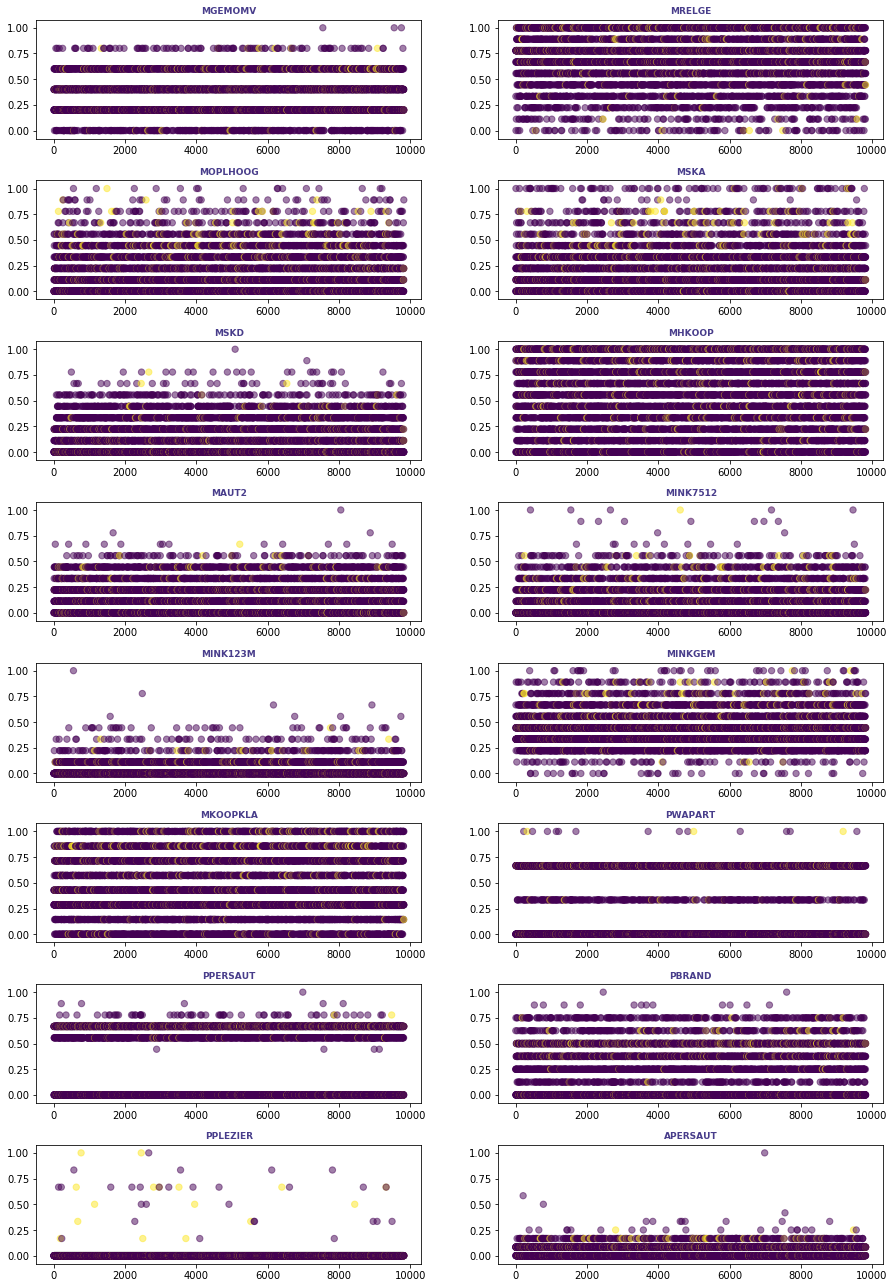

In [6]:
# Plot the feature importances of the forest

plt.figure(figsize=(6 * 2, 2.4 * int(var/2+.5)))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
plt.title("Variable Co-relation with Outcome",size=20)
for i in range(var):
    plt.subplot(8, 2, i+1)
    plt.title(selected[i], size=9,color='darkslateblue',fontweight='bold')
    plt.scatter(range(len(X)),X[:,i], s=40, marker= 'o',c=((y[:,0:1])+0).reshape(-1), alpha=0.5)
    plt.yticks()
    plt.xticks()
plt.show()


###### Feature Reduction thru PCA - Not used in final phase

In [7]:
doPCA = False

if doPCA:
    pca = PCA(svd_solver='randomized',n_components=10,random_state=42).fit(X_train)

    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    #print(pca.components_)
    #print(pca.explained_variance_)
    #print(pca.explained_variance_ratio_) 
    #print(pca.mean_)
    print(pca.n_components_)
    print(pca.noise_variance_)
    plt.figure(1, figsize=(8, 4.5))
    plt.clf()
    plt.axes([.2, .2, .7, .7])
    plt.plot(pca.explained_variance_, linewidth=2)
    plt.axis('tight')
    plt.xlabel('n_components')
    plt.ylabel('explained_variance_')
    plt.show()
else:
    X_train = X_train
    X_val = X_val  

###### Flag for Final Run

In [8]:
Final_Run = True          # Will Not Process Test Set if value is False

### Build Models

###### Decision Tree Classifier

In [9]:
clf_DT = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, 
                                min_samples_split=2, min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, max_features=None, 
                                max_leaf_nodes=None, min_impurity_split=1e-07)
clf_DT.fit(X_train, y_train)
y_pred_DT = clf_DT.predict(X_val)

###### Naive Bayes Classifier

In [10]:
clf_NB = BernoulliNB()
clf_NB.fit(X_train, y_train)
y_pred_NB = clf_NB.predict(X_val)
#print(clf_NB.predict_proba(X_val))

###### Neural Network Classifier

In [11]:
'''
MLPClassifier(activation='relu', alpha=1e-05,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(64), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, validation_fraction=0.1, verbose=True,
       warm_start=False)
clf_MLP = MLPClassifier(alpha=1e-05, hidden_layer_sizes=(64))

clf_MLP.fit(X_train, y_train)
y_pred_MLP = clf_MLP.predict(X_val)
'''

"\nMLPClassifier(activation='relu', alpha=1e-05,\n       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,\n       epsilon=1e-08, hidden_layer_sizes=(64), learning_rate='constant',\n       learning_rate_init=0.001, max_iter=2000, momentum=0.9,\n       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,\n       tol=0.001, validation_fraction=0.1, verbose=True,\n       warm_start=False)\nclf_MLP = MLPClassifier(alpha=1e-05, hidden_layer_sizes=(64))\n\nclf_MLP.fit(X_train, y_train)\ny_pred_MLP = clf_MLP.predict(X_val)\n"

###### Logistic Regression Classifier

In [12]:
#clf_Log = LogisticRegression(solver='sag', max_iter=1000, random_state=42,verbose=2)
clf_Log = LogisticRegression(solver='liblinear', max_iter=1000, 
                             random_state=42,verbose=2,class_weight='balanced')

clf_Log.fit(X_train, y_train)
y_pred_Log = clf_Log.predict(X_val)
print(clf_Log.coef_)
print(clf_Log.intercept_)

[LibLinear][[-0.02564877  1.55143695  1.24521784 -0.94225377  0.10428578  0.29963466
  -1.1021435  -0.80883101 -2.13947438  1.27956159  0.57297117  0.59884233
   1.60387468  0.78044451  3.75042516  0.17107912]]
[-2.99949368]


###### Random Forest Classifier

In [13]:
clf_RF = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=15,
                                min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, 
                                bootstrap=True, oob_score=False, n_jobs=1, 
                                random_state=42, verbose=1, warm_start=False, class_weight=None)
clf_RF.fit(X_train, y_train)
y_pred_RF = clf_RF.predict(X_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


###### AdaBoost Classifier

In [14]:
clf_AdaB = AdaBoostClassifier(n_estimators=100)
clf_AdaB.fit(X_train, y_train)
y_pred_AdaB = clf_AdaB.predict(X_val)

###### Gradient Boost Classifier

In [15]:
clf_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=42)
clf_GB.fit(X_train, y_train)
y_pred_GB = clf_GB.predict(X_val)

###### Extra Tree Classifier

In [16]:
clf_ET = ExtraTreesClassifier(n_estimators=250, random_state=42)
clf_ET.fit(X_train, y_train)
y_pred_ET = clf_ET.predict(X_val)

###### SVM Classifier

In [17]:
clf_SVM = SVC(C=10, class_weight='balanced', gamma='auto', kernel='rbf',
              max_iter=-1, probability=True, random_state=42, verbose=True)
clf_SVM.fit(X_train, y_train)
y_pred_SVM = clf_SVM.predict(X_val)

[LibSVM]

In [18]:
y_val = y_val.reshape(-1)

### Model Performance Comparison

###### Compare Accuracy of Models on Validation Set

In [19]:
print('       Accuracy of Models       ')
print('--------------------------------')
print('Decision Tree           '+"{:.2f}".format(accuracy_score(y_val, y_pred_DT)*100)+'%')
print('Naive Bayes             '+"{:.2f}".format(accuracy_score(y_val, y_pred_NB)*100)+'%')
print('Logistic Regression     '+"{:.2f}".format(accuracy_score(y_val, y_pred_Log)*100)+'%')
print('Random Forest           '+"{:.2f}".format(accuracy_score(y_val, y_pred_RF)*100)+'%')
print('AdaBoost                '+"{:.2f}".format(accuracy_score(y_val, y_pred_AdaB)*100)+'%')
print('GradientBoost           '+"{:.2f}".format(accuracy_score(y_val, y_pred_GB)*100)+'%')
print('Extra Tree              '+"{:.2f}".format(accuracy_score(y_val, y_pred_ET)*100)+'%')
print('Support Vector Machine  '+"{:.2f}".format(accuracy_score(y_val, y_pred_SVM)*100)+'%')

       Accuracy of Models       
--------------------------------
Decision Tree           84.65%
Naive Bayes             67.12%
Logistic Regression     66.46%
Random Forest           92.10%
AdaBoost                92.25%
GradientBoost           93.21%
Extra Tree              92.00%
Support Vector Machine  73.71%


###### Print Confusion Matrix for all Models

In [20]:
print('Decision Tree  ')
cm_DT = confusion_matrix(y_val,y_pred_DT)
print(cm_DT)
print('\n')

print('Naive Bayes  ')
cm_NB = confusion_matrix(y_val,y_pred_NB)
print(cm_NB)
print('\n')

print('Logistic Regression  ')
cm_Log = confusion_matrix(y_val,y_pred_Log)
print(cm_Log)
print('\n')

print('Random Forest  ')
cm_RF = confusion_matrix(y_val,y_pred_RF)
print(cm_RF)
print('\n')

print('AdaBoost  ')
cm_AdaB = confusion_matrix(y_val,y_pred_AdaB)
print(cm_AdaB)
print('\n')

print('GradientBoost  ')
cm_GB = confusion_matrix(y_val,y_pred_GB)
print(cm_GB)
print('\n')

print('Extra Tree  ')
cm_ET = confusion_matrix(y_val,y_pred_ET)
print(cm_ET)
print('\n')

print('SVM  ')
cm_SVM = confusion_matrix(y_val,y_pred_SVM)
print(cm_SVM)

Decision Tree  
[[1640  219]
 [  84   31]]


Naive Bayes  
[[1261  598]
 [  51   64]]


Logistic Regression  
[[1237  622]
 [  40   75]]


Random Forest  
[[1802   57]
 [  99   16]]


AdaBoost  
[[1802   57]
 [  96   19]]


GradientBoost  
[[1830   29]
 [ 105   10]]


Extra Tree  
[[1807   52]
 [ 106    9]]


SVM  
[[1386  473]
 [  46   69]]


### Test Set Results

###### Compare Models on Training, Validation and Test Set Results

###### Execute only on Final Run

In [21]:
if Final_Run:
    if doPCA:
        X_test = pca.transform(X_test)
        X_train_original = pca.transform(X_train_original)
    y_test = y_test.reshape(-1)
    y_train_original = y_train_original.reshape(-1)
    
    y_pred_train_DT = clf_DT.predict(X_train_original)
    y_pred_train_NB = clf_NB.predict(X_train_original)
    y_pred_train_Log = clf_Log.predict(X_train_original)
    y_pred_test_DT = clf_DT.predict(X_test)
    y_pred_test_NB = clf_NB.predict(X_test)
    y_pred_test_Log = clf_Log.predict(X_test)
    cm_DT_train = confusion_matrix(y_train_original,y_pred_train_DT)
    cm_NB_train = confusion_matrix(y_train_original,y_pred_train_NB)
    cm_Log_train = confusion_matrix(y_train_original,y_pred_train_Log)
    cm_DT_test = confusion_matrix(y_test,y_pred_test_DT)
    cm_NB_test = confusion_matrix(y_test,y_pred_test_NB)
    cm_Log_test = confusion_matrix(y_test,y_pred_test_Log)
    
    print('Decision Tree Classification Matrix  ')
    print('Training')
    print(cm_DT_train)
    print('Validation')
    print(cm_DT)
    print('Test')
    print(cm_DT_test)
    print('\n')

    print('Naive Bayes Classification Matrix ')
    print('Training')
    print(cm_NB_train)
    print('Validation')
    print(cm_NB)
    print('Test')
    print(cm_NB_test)
    print('\n')

    print('Logistic Regression Classification Matrix ')
    print('Training')
    print(cm_Log_train)
    print('Validation')
    print(cm_Log)
    print('Test')
    print(cm_Log_test)
    print('\n')

Decision Tree Classification Matrix  
Training
[[5844  627]
 [ 178  226]]
Validation
[[1640  219]
 [  84   31]]
Test
[[800 106]
 [ 43  24]]


Naive Bayes Classification Matrix 
Training
[[4456 2015]
 [ 181  223]]
Validation
[[1261  598]
 [  51   64]]
Test
[[627 279]
 [ 26  41]]


Logistic Regression Classification Matrix 
Training
[[4332 2139]
 [ 119  285]]
Validation
[[1237  622]
 [  40   75]]
Test
[[597 309]
 [ 19  48]]




###### Choose Final Model

Choosing Decision Tree Model as Final Model due to Accuracy + Simplicity

In [22]:
clf = clf_NB

###### Execute only on Final Run

Feature ranking:
1. MINKGEM (0.111482)
2. PPERSAUT (0.103324)
3. MRELGE (0.091884)
4. MINK7512 (0.083063)
5. MOPLHOOG (0.082900)
6. PBRAND (0.079321)
7. MKOOPKLA (0.066908)
8. MGEMOMV (0.062633)
9. MSKA (0.058526)
10. MAUT2 (0.055982)
11. MHKOOP (0.049739)
12. APERSAUT (0.046994)
13. MSKD (0.046766)
14. MINK123M (0.031748)
15. PWAPART (0.020702)
16. PPLEZIER (0.008027)


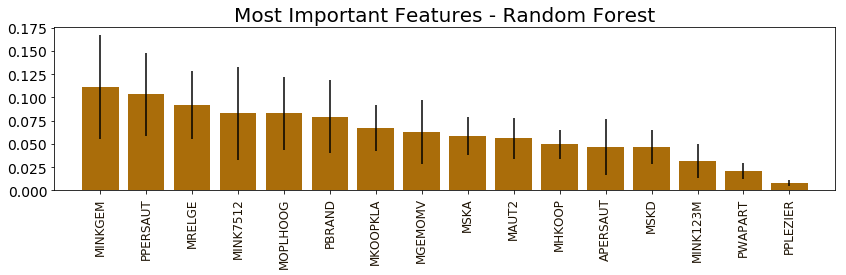

In [23]:
importances_RF = clf_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_RF.estimators_],
             axis=0)
indices1 = np.argsort(importances_RF[0:var])[::-1]

indices = indices1[0:var]
# Print the feature ranking
print("Feature ranking:")

for f in range(var):
    print("%d. %s (%f)" % (f + 1, (dataset.columns.values[[3,10,16,25,29,31,33,40,41,42,43,44,47,59,61,68]]).reshape(-1)[indices[f]], importances_RF[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(14, 3))
plt.title("Most Important Features - Random Forest",size=20)
plt.bar(range(var), importances_RF[indices],
       color="#aa6d0a", yerr=std[indices], align="center")
plt.yticks(size=14)
plt.xticks(range(var), (dataset.columns.values[[3,10,16,25,29,31,33,40,41,42,43,44,47,59,61,68]]).reshape(-1)[indices],rotation='vertical',size=12,color="#201506")
plt.xlim([-1, var])
plt.show()

In [24]:
FN_amount = -9950
TP_amount = 9950
TN_amount = 0
FP_amount = -50

if Final_Run:
    print('Compare Profit from Models - Test Set')
    print('-------------------------------------')

    Profit_DT     = (cm_DT_test[0][0]*TN_amount + cm_DT_test[1][0]*FN_amount + cm_DT_test[0][1]*FP_amount +
                   cm_DT_test[1][1]*TP_amount)
    print('Decision Tree Profit(Rs):        ' + str(Profit_DT))

    Profit_NB     = (cm_NB_test[0][0]*TN_amount + cm_NB_test[1][0]*FN_amount + cm_NB_test[0][1]*FP_amount + 
                  cm_NB_test[1][1]*TP_amount)
    print('Naive Bayes Profit(Rs):          ' + str(Profit_NB))

    Profit_Log    = (cm_Log_test[0][0]*TN_amount + cm_Log_test[1][0]*FN_amount + cm_Log_test[0][1]*FP_amount + 
                  cm_Log_test[1][1]*TP_amount)
    print('Logistic Regression Profit(Rs):  ' + str(Profit_Log))
    
    
    y_pred_test = clf.predict(X_test)
    print('\n\nBest Model Accuracy on Test Set: '+"{:.2f}".format(accuracy_score(y_test, y_pred_test)*100)+'%')
    print('\nConfusion Matrix on Test Set  ')
    cm = confusion_matrix(y_test,y_pred_test)
    print(cm)
    print('\n')
    Profit = cm[0][0]*TN_amount + cm[1][0]*FN_amount + cm[0][1]*FP_amount + cm[1][1]*TP_amount
    print('Profit(Rs) for Test Set:        ' + str(Profit))
    
    # Checked Actual Positive and Negative Class in Test Set
    Max_Profit = 146*TN_amount + 0*FN_amount + 0*FP_amount + 4*TP_amount
    print('Max_Profit = ' + str(Max_Profit))
    
    print('\n')
    print('Test Set Profit % w.r.t Maximum Profit: ' + "{:.2f}".format(float(Profit)/Max_Profit*100)+'%')
    print('\n')
    print('Final Model')
    print('-----------')
    print(str(clf))

Compare Profit from Models - Test Set
-------------------------------------
Decision Tree Profit(Rs):        -194350
Naive Bayes Profit(Rs):          135300
Logistic Regression Profit(Rs):  273100


Best Model Accuracy on Test Set: 68.65%

Confusion Matrix on Test Set  
[[627 279]
 [ 26  41]]


Profit(Rs) for Test Set:        135300
Max_Profit = 39800


Test Set Profit % w.r.t Maximum Profit: 339.95%


Final Model
-----------
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)


In [25]:
print(str(clf_DT));print('\n')
print(str(clf_NB));print('\n')
print(str(clf_Log));print('\n')
print(str(clf_RF));print('\n')
print(str(clf_AdaB));print('\n')
print(str(clf_GB));print('\n')
print(str(clf_ET));print('\n')
print(str(clf_SVM));print('\n')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=1e-07,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_im

In [26]:
# save
joblib.dump(clf_RF, "./rf_model.joblib")

['./rf_model.joblib']